In [1]:
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.5, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_val = x_val.astype("float32") / 255.0
x_val = np.reshape(x_val, (-1, 28, 28, 1))
y_val = tf.keras.utils.to_categorical(y_val, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(256)

In [3]:
def make_htr_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Softmax())
    return model

In [4]:
htr_model = make_htr_model()    
mnist_gen = tf.keras.models.load_model("mnist_gan.keras")
boundaries = [1000, 3000, 5000]
values = [1e-3, 3e-4, 1e-4, 1e-5]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

optimizer = tf.keras.optimizers.Adam(learning_rate_fn, beta_1=0.9)


In [5]:
htr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 10)                6

In [6]:
mnist_gen.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6762)              939918    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6762)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [7]:
import tensorflow as tf

# Load the pre-trained model without the top dense layers
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Define input layer
input_data = tf.keras.Input(shape=(28, 28, 3))

# Resize the input to match the input shape of the pre-trained VGG model
resized_input = tf.keras.layers.Resizing(32, 32)(input_data)

# Pass the resized input through the pre-trained model up to the desired layer
desired_layer_name = 'block3_conv1'  # Example: Output from block3_conv1 layer
desired_layer_output = tf.keras.models.Sequential(model.layers[:12])(resized_input)

# Create a new model with input and output up to the desired layer
vgg_model = tf.keras.Model(inputs=input_data, outputs=desired_layer_output)

# Summary of the modified VGG model
vgg_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 4, 4, 512)         2915648   
                                                                 
Total params: 2,915,648
Trainable params: 2,915,648
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [9]:
def save_images(epoch, imgs, labels, pred_labels, true_imgs, loss_dir, plot=False):
    labels_numbers = np.argmax(labels, axis=1)
    pred_labels_numbers = np.argmax(pred_labels, axis=1)

    fig = plt.figure(figsize=(16, 8))
    plot_idx = 1
    for i in range(imgs.shape[0]):
        # print(losses[i])
        fig.add_subplot(4, 8, plot_idx )
        pred_str = ""
        # print(pred_labels[i])
        for j in pred_labels[i]:
            pred_str += "," + str(j)[:4]
        plt.title(f"gt: {labels_numbers[i]}, \npred: {pred_labels_numbers[i]}\n" + pred_str, fontsize=6.5)
        plt.imshow(true_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        fig.add_subplot(4, 8, plot_idx + 1)
        plt.imshow(imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
 
        plot_idx += 2
    dir_path = './synth_imgs/' + loss_dir +'/'
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(dir_path + 'images_at_epoch_{:04d}.png'.format(epoch))
    if plot:
        plt.show()
    plt.close()


In [10]:
@tf.function
def train_step(data):
    images, one_hot_labels = data

    random_latent_vectors = tf.random.normal(
        shape=(tf.shape(images)[0], latent_dim), seed=1337
    )
    # random_label_noise = tf.random.normal(shape=(tf.shape(images)[0], 10), mean=0, stddev=0.2)

    with tf.GradientTape() as tape:
        pred_labels = htr_model(images, training=True)

        random_vector_labels = tf.concat(
            [random_latent_vectors, pred_labels], axis=-1
        )

        gen_imgs = mnist_gen(random_vector_labels, training=False)
        # loss_mse = tf.reduce_mean((gen_imgs - images) ** 2)
        # loss_ssim = 1 - tf.reduce_mean(tf.image.ssim(images, gen_imgs, 1, filter_size=7))
        # loss = 10*loss_mse + loss_ssim #- 0.1*tf.reduce_mean(tf.reduce_max(pred_labels, axis=1))

        images_in = tf.concat([images] * 3, axis=-1)
        images_gen = tf.concat([gen_imgs] * 3, axis=-1)

        loss = tf.reduce_mean((vgg_model(images_in) - vgg_model(images_gen))**2)
        # loss = tf.keras.losses.BinaryCrossentropy()(images, gen_imgs)
        
    grads = tape.gradient(loss, htr_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, htr_model.trainable_weights))
    
    return loss

In [11]:


def validate(data):
    val_losses = []
    accuracies = []
    for image_batch in data:
        x_val, y_val = image_batch
        # print(x_val.shape, y_val.shape, tf.shape(x_val))
        y_preds = htr_model.predict(x_val, verbose=0)
        # print(tf.shape(y_preds))
        y_preds_one_hot = tf.keras.utils.to_categorical(np.argmax(y_preds, axis=1), num_classes)
        accuracy = accuracy_score(y_true=y_val, y_pred=y_preds_one_hot)
        accuracies.append(accuracy)

        random_latent_vectors = tf.random.normal(
            shape=(tf.shape(x_val)[0], latent_dim), seed=1337
        )
        # print(tf.shape(random_latent_vectors))

        random_vector_labels = tf.concat(
                [random_latent_vectors, y_preds], axis=1
            )
        
        synth_imgs = mnist_gen(random_vector_labels, training=False)

        images_in = tf.concat([x_val] * 3, axis=-1)
        images_gen = tf.concat([synth_imgs] * 3, axis=-1)

        val_loss = tf.reduce_mean((vgg_model(images_in) - vgg_model(images_gen))**2)
        # val_loss = tf.keras.losses.BinaryCrossentropy()(x_val, synth_imgs)
        val_losses.append(val_loss)
    np.set_printoptions(suppress=True, precision=4)
    # print(np.round(y_preds[:16], 4))
    return np.mean(val_losses), np.mean(accuracies), synth_imgs[:16], x_val[:16], y_val[:16], y_preds[:16]

In [12]:
from tqdm import tqdm

g_loss = []
val_losses = []
accuracies = []
all_batch_losses = []

for epoch in tqdm(range(100)):
    batch_losses = []
    for batch in dataset:
        loss = train_step(batch)
        batch_losses.append(loss)
        all_batch_losses.append(loss)

    g_loss.append(np.mean(batch_losses))
    
    val_loss, acc, synth_imgs, x_val, y_val, y_preds = validate(val_dataset)
    save_images(epoch, synth_imgs, y_val, y_preds, x_val, 'vgg')
    val_losses.append(val_loss)
    print(acc)
    accuracies.append(acc)


  0%|          | 0/100 [00:00<?, ?it/s]

  9%|▉         | 9/100 [02:14<21:14, 14.01s/it]

In [ ]:
import glob
# Make gif
dir_path = './results/vgg/'
os.makedirs(dir_path)
with imageio.get_writer(dir_path + '/anims.gif', mode='I') as writer:
    filenames = glob.glob('./synth_imgs/vgg/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    

C:\Users\Lisa\AppData\Local\Temp\ipykernel_6980\525499271.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
np.save('./train_losses_batch_vgg.npy', all_batch_losses)
np.save('./train_losses_epoch_vgg.npy', g_loss)
np.save('./validation_losses_vgg.npy', val_losses)
np.save('./validation_acc_vgg.npy', accuracies)


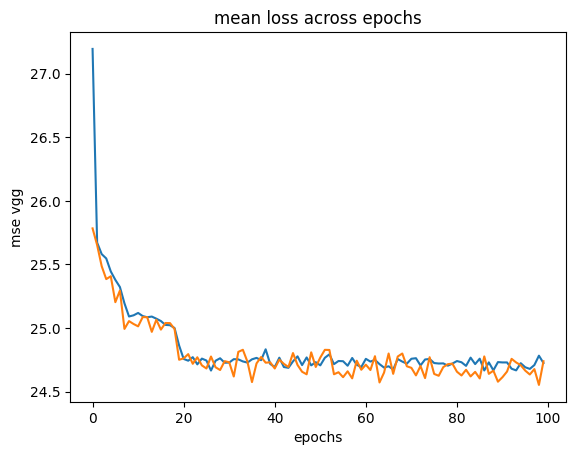

In [ ]:
from matplotlib import pyplot as plt
# htr_model.save("htr_model_vgg.keras")

plt.plot(g_loss, label = "training loss")
plt.plot(val_losses, label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("mse vgg")
plt.title("mean loss across epochs")
plt.savefig("MeanvggEpochs.png", dpi=300, bbox_inches="tight")
plt.show()


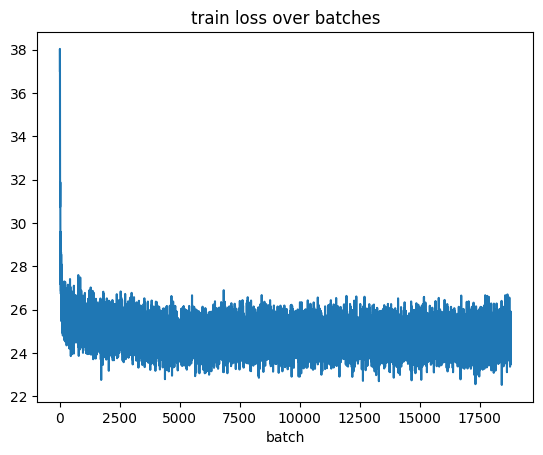

In [ ]:


plt.plot(all_batch_losses)
plt.xlabel("batch")
plt.title("train loss over batches")
plt.show()

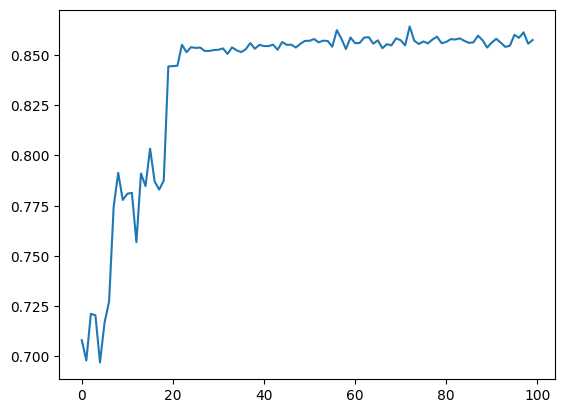

In [ ]:
plt.plot(accuracies)
plt.show()

In [ ]:
g_loss[-1]
accuracies[-1]

0.8575109232522797

In [ ]:
data = list(dataset.take(100))
images, one_hot_labels = data[0]

In [ ]:
images.shape

TensorShape([256, 28, 28, 1])

In [ ]:
pred_labels = htr_model(images[:5], training=False)
print(tf.one_hot(tf.argmax(pred_labels, axis=1), 10))
one_hot_labels[:5]

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

tf.Tensor([5], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.998 0.    0.    0.    0.   ]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.079 0.819 0.06  0.    0.    0.002 0.038 0.    0.   ]]
tf.Tensor([1], shape=(1,), dtype=int64) [[0.    0.992 0.001 0.    0.    0.001 0.001 0.005 0.    0.   ]]
tf.Tensor([0], shape=(1,), dtype=int64) [[0.364 0.039 0.001 0.019 0.001 0.033 0.393 0.001 0.001 0.148]]
tf.Tensor([9], shape=(1,), dtype=int64) [[0.    0.003 0.    0.    0.001 0.    0.    0.002 0.    0.993]]
tf.Tensor([4], shape=(1,), dtype=int64) [[0.    0.013 0.    0.    0.977 0.    0.    0.002 0.    0.008]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.003 0.986 0.002 0.    0.    0.    0.005 0.    0.004]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.003 0.    0.001 0.989 0.005]]
tf.Tensor([5], shape=(1,), dtype=int64) [[0.004 0.26  0.    0.    0.    0.727 0.    0.001 0.006 0.001]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.002 0.001 0.    0.00

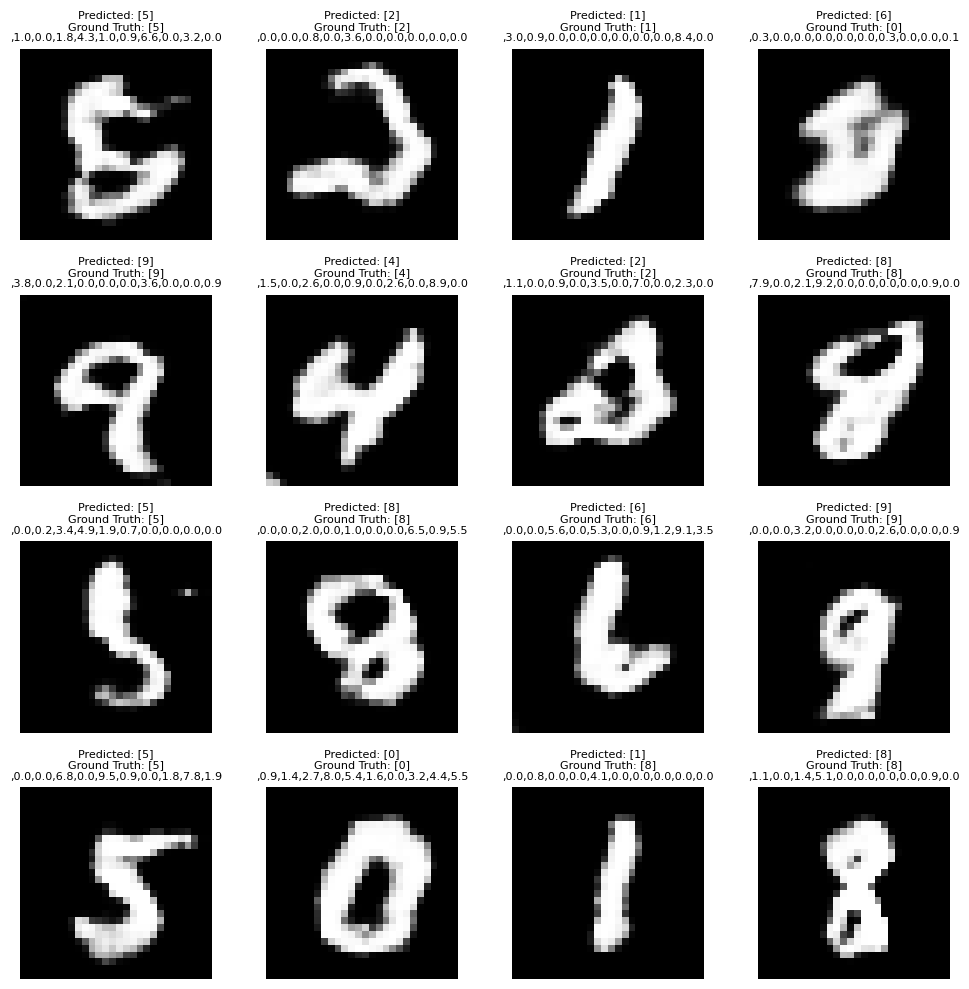

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

for i in range(16):
    pred = htr_model(images[i:(i+1)], training=False)

    pred_label = tf.argmax(pred, axis=1)
    
    gt_label = tf.argmax(one_hot_labels[i:(i+1)], axis=1)

    random_latent_vectors = tf.random.normal(
        shape=(1, latent_dim), seed=21
    )

    random_vector_labels = tf.concat(
        [random_latent_vectors, pred], axis=-1
    )
    gen_img = mnist_gen(random_vector_labels, training=False)
    # Plot image
    axs[i].imshow(tf.squeeze(gen_img), cmap='gray')
    axs[i].axis('off')  # Turn off axis
    
    # Add text above each pair of plots indicating predicted class and ground truth
    print(gt_label, np.round(pred.numpy(), 3))
    pred_str = ""
    for j in pred[0]:
        pred_str += "," + str(j.numpy())[:3]
    text = f'Predicted: {pred_label}\nGround Truth: {gt_label}\n' + pred_str
    axs[i].set_title(text, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def compute_accuracy(true_labels, predicted_labels):
    """
    Compute accuracy between true labels and predicted labels.

    Args:
    true_labels (list): List of true labels.
    predicted_labels (list): List of predicted labels.

    Returns:
    float: Accuracy as a value between 0 and 1.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Length of true labels and predicted labels must be the same.")

    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_samples = len(true_labels)

    accuracy = correct_predictions / total_samples if total_samples != 0 else 0

    return accuracy


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(256)

acc = []
for batch in tqdm(test_dataset):
    images, one_hot_labels = batch
    preds = htr_model(images, training=False)
    pred_labels = tf.argmax(preds, axis=1)
    gt_labels = tf.argmax(one_hot_labels, axis=1)
    acc.append(compute_accuracy(gt_labels, pred_labels))

print("Accuracy: ", np.mean(acc)*100)

100%|██████████| 40/40 [00:10<00:00,  3.94it/s]

Accuracy:  86.103515625
